# FISH - Pipeline - A Python interactive notebook to process FISH data

```
Author: Luis U. Aguilera
Contact Info: luis.aguilera@colostate.edu

Copyright (c) 2021 Munsky Group 
Colorado State University 
Licensed under BSD 3-Clause License.
```

### Notebook summary 


- Load a directory with microscope FISH images
- Establish a connection to Network-attached storage (NAS) using [pysmb](https://github.com/miketeo/pysmb)
- Perform cell segmentation using [Cellpose](https://github.com/MouseLand/cellpose)
- Perform spot detection using [Big-FISH](https://github.com/fish-quant/big-fish)
- Datamanagement using Pandas

----

<img src= /home/luisub/Desktop/FISH_Processing/docs/images/code_architecture.png alt="drawing" width="1000"/>

### Libraries

In [1]:
# Importing libraries
import sys
import matplotlib.pyplot as plt 
import numpy as np 
import pathlib
import warnings
import shutil
import zipfile
import os
warnings.filterwarnings("ignore")

### Path to source directories

In [2]:
# Deffining directories
current_dir = pathlib.Path().absolute()
fa_dir = current_dir.parents[0].joinpath('src')

# Importing fish_analyses module
sys.path.append(str(fa_dir))
import fish_analyses as fa

----

# Parameters defined by the user 

----

### Paths to images

In [3]:
# Path to credentials
desktop_path = pathlib.Path.home()/'Desktop'
path_to_config_file = desktop_path.joinpath('config.yml')

### Remote directories
#data_folder_path = pathlib.Path('Test','test_dir')
#data_folder_path =pathlib.Path('smFISH_images/Linda_smFISH_images/Confocal/20220314/GAPDH-Cy3_COX-2-Cy5_wo_IL-1B' )
#data_folder_path =pathlib.Path('smFISH_images/Linda_smFISH_images/Confocal/20220314/GAPDH-Cy3_COX-2-Cy5_30ng_ml_IL-1B_2h' )
#data_folder_path =pathlib.Path('smFISH_images/Linda_smFISH_images/Confocal/20220314/GAPDH-Cy3_COX-2-Cy5_30ng_ml_IL-1B_6h' )
#data_folder_path =pathlib.Path('smFISH_images/Linda_smFISH_images/Confocal/20220314/GAPDH-Cy3_COX-2-Cy5_100ng_ml_IL-1B_2h' )
#data_folder_path =pathlib.Path('smFISH_images/Linda_smFISH_images/Confocal/20220314/GAPDH-Cy3_COX-2-Cy5_100ng_ml_IL-1B_6h' )
#data_folder_path =pathlib.Path('smFISH_images/Linda_smFISH_images/Confocal/20220315/GAPDH-Cy3_COX-2-Cy5_300ng_ml_IL-1B_2h' )
#data_folder_path =pathlib.Path('smFISH_images/Linda_smFISH_images/Confocal/20220315/GAPDH-Cy3_COX-2-Cy5_300ng_ml_IL-1B_6h' )
#data_folder_path =pathlib.Path('smFISH_images/Linda_smFISH_images/Confocal/20220114/GAPDH-Cy3_NFKBIA-Cy5_woDex' )
#data_folder_path =pathlib.Path('smFISH_images/Linda_smFISH_images/Confocal/20220216/GAPDH-Cy3_NFKBIA-Cy5_10min_100nM_DEX_Rep2')
#data_folder_path =pathlib.Path('smFISH_images/Eric_smFISH_images/20211109/MS2_Cy3_TPL_0min')
#path_to_masks_dir = None   # full path to a zip file
#path_to_masks_dir = pathlib.Path('Test/test_dir/masks_test_dir___nuc_120__cyto_220.zip')
#download_data_from_NAS = True
#send_data_to_NAS=False

#### Local directories
data_folder_path = current_dir.parents[0].joinpath('dataBases').joinpath('tests')
path_to_masks_dir = None #current_dir.parents[0].joinpath('dataBases').joinpath('masks_test_data')
download_data_from_NAS = False
send_data_to_NAS=False

### Parameters for segmentation and spot detection

In [4]:
# Parameters fo cell segmentation 
channels_with_cytosol =  None # [0,2]             # list or int indicating the channels where the cytosol is detectable
channels_with_nucleus = [0,0]           # list or int indicating the channels where the nucleus is detectable
channels_with_FISH = [1]              # list or int with the channels with FISH spots that are used for the quantification
diameter_nucleus = 170                # approximate nucleus size in pixels
diameter_cytosol = 200                # approximate cytosol size in pixels

# Parameters for FISH detection
voxel_size_z = 500    #300                      # Microscope conversion px to nanometers in the z axis.
voxel_size_yx = 103 #103   #103                 # Microscope conversion px to nanometers in the xy axis.
psf_z = 350      #350                           # Theoretical size of the PSF emitted by a [rna] spot in the z plan, in nanometers.
psf_yx = 120     #150                           # Theoretical size of the PSF emitted by a [rna] spot in the yx plan, in nanometers.
list_voxels = [ voxel_size_z,voxel_size_yx ]
list_psfs = [psf_z, psf_yx ]

# Cluster Detection
minimum_spots_cluster = 2                  # The number of spots in a neighborhood for a point to be considered as a core point (from which a cluster is expanded). This includes the point itself.
show_plots = True                          # Flag to display plots
optimization_segmentation_method = 'z_slice_segmentation'    # optimization_segmentation_method = 'intensity_segmentation' 'z_slice_segmentation', 'gaussian_filter_segmentation' ,  'center_slice', None
save_all_images=False                     # If true, it shows a all planes for the FISH plot detection. 
threshold_for_spot_detection = None       # Intensity threshold to detect  spots. If None, it will automatically detect the spots.

use_brute_force=True

In [5]:
# names for final folders
name_final_folder = data_folder_path.name +'___nuc_' + str(diameter_nucleus) + '__cyto_' + str(diameter_cytosol) + '__psfz_' + str(psf_z) + '__psfyx_' + str(psf_yx) 


## Connecting to NAS and Downloading data

In [6]:
def download_data_NAS(path_to_config_file,data_folder_path, path_to_masks_dir,share_name,timeout=200):
    # Downloading data from NAS
    local_folder_path = pathlib.Path().absolute().joinpath('temp_' + data_folder_path.name)
    fa.NASConnection(path_to_config_file,share_name = share_name).copy_files(data_folder_path, local_folder_path,timeout=timeout)
    local_data_dir = local_folder_path     # path to a folder with images.
    # Downloading masks from NAS
    if not (path_to_masks_dir is None):
        local_folder_path_masks = pathlib.Path().absolute().joinpath( path_to_masks_dir.stem  )
        zip_file_path = local_folder_path_masks.joinpath( path_to_masks_dir.stem +'.zip')
        print(zip_file_path)
        fa.NASConnection(path_to_config_file,share_name = share_name).download_file(path_to_masks_dir, local_folder_path_masks,timeout=timeout)
        # Unzip downloaded images and update mask directory
        file_to_unzip = zipfile.ZipFile(str(zip_file_path)) # opens zip
        # Iterates for each file in zip file
        for file_in_zip in file_to_unzip.namelist():
            # Extracts data to specific folder
            file_to_unzip.extract(file_in_zip,local_folder_path_masks)
        # Closes the zip file
        file_to_unzip.close()
        # removes the original zip file
        os.remove(zip_file_path)
        masks_dir = local_folder_path_masks
    else:
        masks_dir = None
    return local_data_dir, masks_dir

In [7]:
# Download data from NAS
if download_data_from_NAS == True:
    share_name = 'share'
    local_data_dir, masks_dir= download_data_NAS(path_to_config_file,data_folder_path, path_to_masks_dir,share_name,timeout=200)
else:
    local_data_dir = data_folder_path 
    masks_dir = path_to_masks_dir 

In [8]:
# Detecting if images need to be merged
is_needed_to_merge_images = fa.MergeChannels(local_data_dir, substring_to_detect_in_file_name = '.*_C0.tif', save_figure =1).checking_images()
if is_needed_to_merge_images == True:
    list_file_names, list_images, number_images, output_to_path = fa.MergeChannels(local_data_dir, substring_to_detect_in_file_name = '.*_C0.tif', save_figure =1).merge()
    local_data_dir = local_data_dir.joinpath('merged')

## Running the pipeline

----

 ############### 
       IMAGE : 0
 ############### 
 
ORIGINAL IMAGE
ROI013_XY1634228282_Z00_T0_merged.tif
(27, 928, 624, 3)


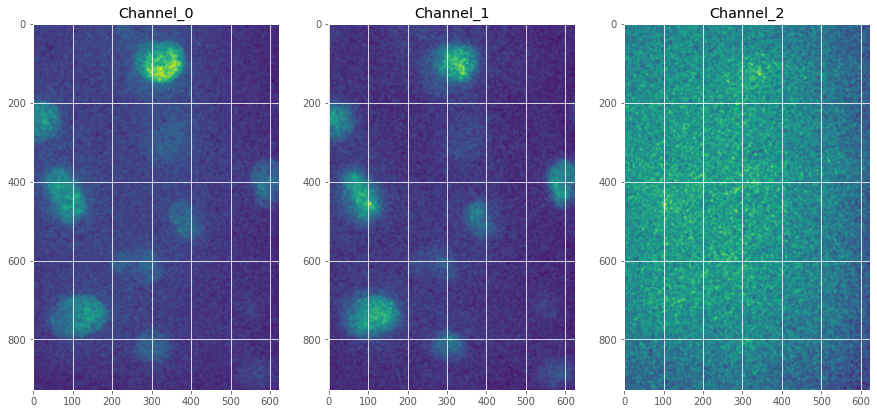

CELL SEGMENTATION


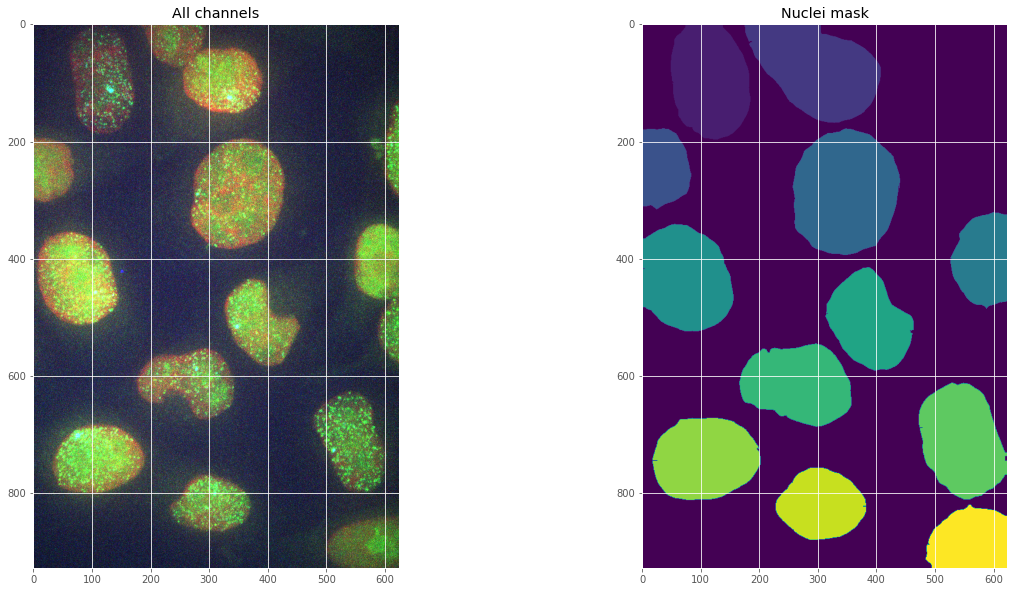

No paired masks were detected for this image
SPOT DETECTION
Spot Detection for Channel : 1
sigma_value (z,y,x) = (0.7, 1.1650485436893203, 1.1650485436893203)
Int threshold used for the detection of spots:  392.0


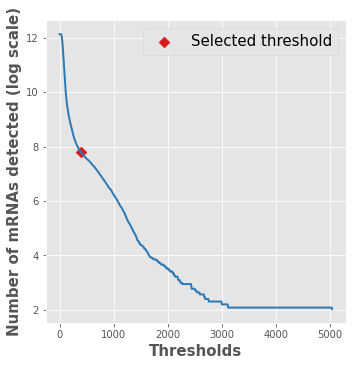

Z-Slice:  13


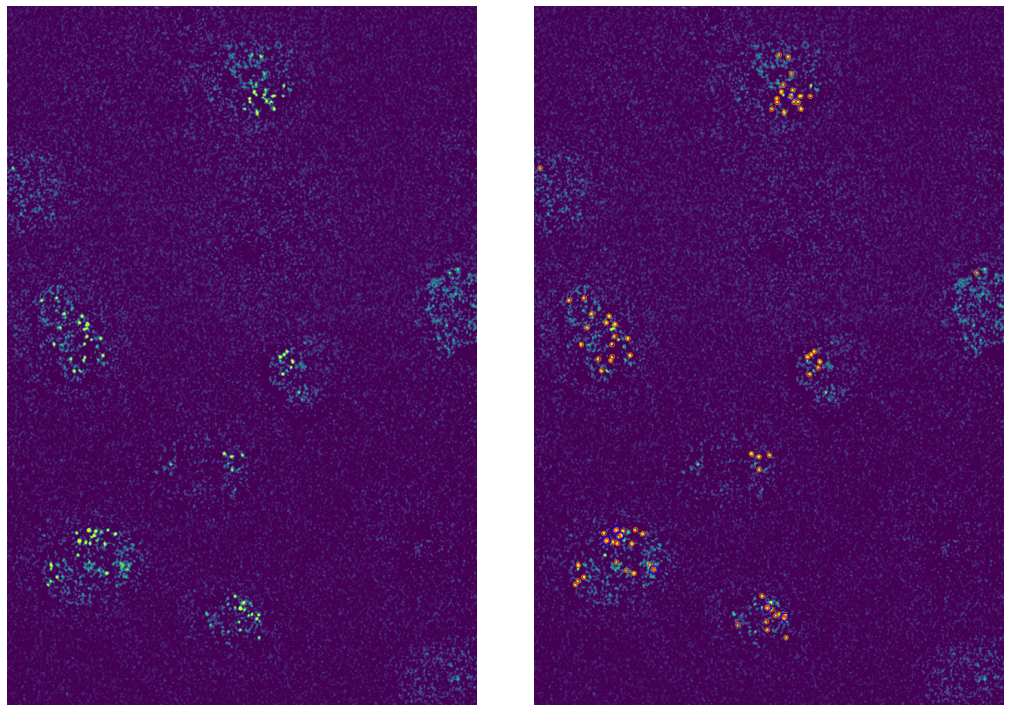

In [9]:
dataframe_FISH,_,_,_ = fa.PipelineFISH(local_data_dir, channels_with_cytosol, channels_with_nucleus, channels_with_FISH,diameter_nucleus, diameter_cytosol, minimum_spots_cluster, masks_dir=masks_dir,  list_voxels=list_voxels, list_psfs=list_psfs, show_plot=show_plots, file_name_str =data_folder_path.name, optimization_segmentation_method = optimization_segmentation_method,save_all_images=save_all_images,threshold_for_spot_detection=threshold_for_spot_detection,use_brute_force=True  ).run()

## Extracting data from the dataframe

----

In [10]:
# Be aware that the code keeps track of cells without spots. In the data frame, the fields for cells without spots are populated with -1 values.
dataframe_FISH.tail()

,image_id,cell_id,spot_id,nucleus_y,nucleus_x,nuc_area_px,cyto_area_px,cell_area_px,z,y,x,is_nuc,is_cluster,cluster_size,spot_type,is_cell_fragmented,flag_empty_cell
2304,0,11,4,880,559,12504,0,0,6,864,586,1,0,0,0,1,0.0
2305,0,11,5,880,559,12504,0,0,6,885,596,1,0,0,0,1,0.0
2306,0,11,6,880,559,12504,0,0,6,888,566,1,0,0,0,1,0.0
2307,0,11,7,880,559,12504,0,0,10,893,573,1,0,0,0,1,0.0
2308,0,11,8,880,559,12504,0,0,11,897,595,1,0,0,0,1,0.0


In [11]:
# Number of cells
spot_type_selected = 0
number_cells = dataframe_FISH['cell_id'].nunique()
print(number_cells)
# Number of spots
number_of_spots_per_cell = [len( dataframe_FISH.loc[  (dataframe_FISH['cell_id']==i)  & (dataframe_FISH['spot_type']==spot_type_selected) ].spot_id) for i in range(0, number_cells)]
# Number of spots in cytosol
number_of_spots_per_cell_cytosol = [len( dataframe_FISH.loc[  (dataframe_FISH['cell_id']==i) & (dataframe_FISH['is_nuc']==False) & (dataframe_FISH['spot_type']==spot_type_selected) & (dataframe_FISH['is_cell_fragmented']!=-1) ].spot_id) for i in range(0, number_cells)]
# Number of spots in nucleus
number_of_spots_per_cell_nucleus = [len( dataframe_FISH.loc[  (dataframe_FISH['cell_id']==i) &  (dataframe_FISH['is_cluster']==False) & (dataframe_FISH['is_nuc']==True) & (dataframe_FISH['spot_type']==spot_type_selected)  & (dataframe_FISH['is_cell_fragmented']!=-1)   ].spot_id) for i in range(0, number_cells)]
# Number of TS per cell.
number_of_TS_per_cell = [len( dataframe_FISH.loc[  (dataframe_FISH['cell_id']==i) &  (dataframe_FISH['is_cluster']==True) & (dataframe_FISH['is_nuc']==True) & (dataframe_FISH['spot_type']==spot_type_selected) & (dataframe_FISH['cluster_size'] >=4) & (dataframe_FISH['is_cell_fragmented']!=-1) ].spot_id) for i in range(0, number_cells)]
# Number of RNA in a TS
ts_size =  dataframe_FISH.loc[   (dataframe_FISH['is_cluster']==True) & (dataframe_FISH['is_nuc']==True)  & (dataframe_FISH['spot_type']==spot_type_selected) & (dataframe_FISH['is_cell_fragmented']!=-1)  ].cluster_size.values
# Size of each cell
cell_size = dataframe_FISH.loc[  (dataframe_FISH['spot_id']==0)  ].cell_area_px.values

12


## Plotting

----

In [12]:
# Plotting intensity distributions
plt.style.use('ggplot')  # ggplot  #default
def plot_probability_distribution(data_to_plot, numBins = 10, title='', xlab='', ylab='', color='r', subplots=False, show_grid=True, fig=plt.figure() ):
  n, bins, _ = plt.hist(data_to_plot,bins=numBins,density=False,color=color)
  plt.xlabel(xlab, size=16)
  plt.ylabel(ylab, size=16)
  plt.grid(show_grid)
  plt.text(bins[(len(bins)//2)],(np.amax(n)//2).astype(int),'mean = '+str(round( np.mean(data_to_plot) ,1) ), fontsize=14,bbox=dict(facecolor='w', alpha=0.5) )
  plt.title(title, size=16)
  return (f)

<Figure size 432x288 with 0 Axes>

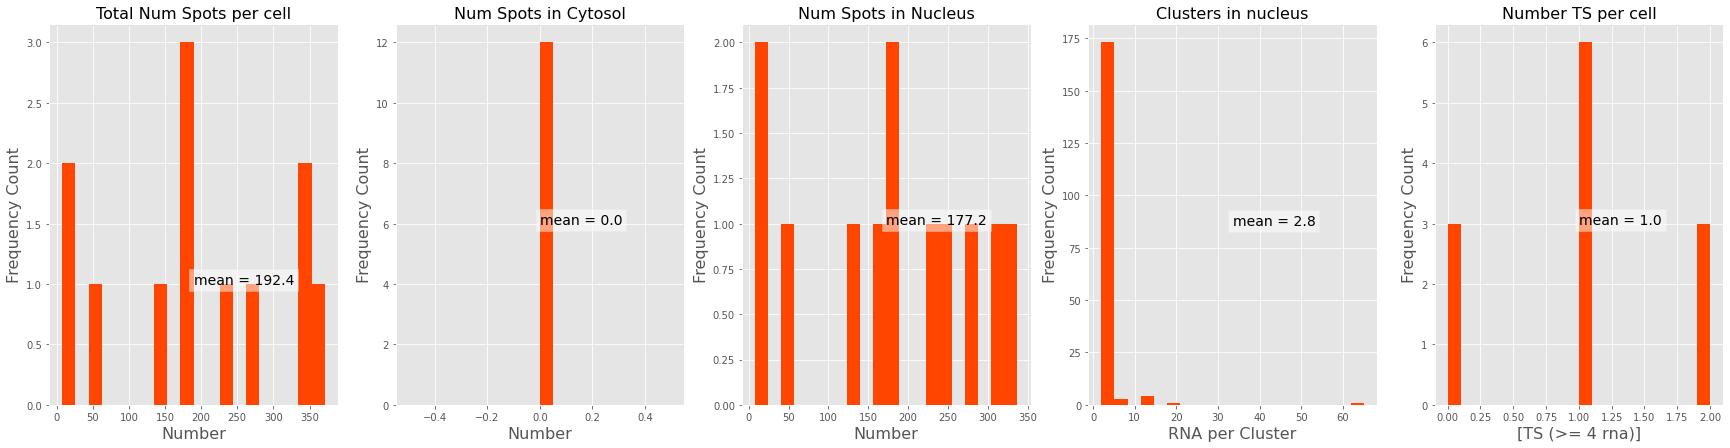

In [13]:
#Plotting
fig_size = (30, 7)
f = plt.figure(figsize=fig_size)
#ylab='Probability'
ylab='Frequency Count'  
# adding subplots
f.add_subplot(1,5,1) 
plot_probability_distribution( number_of_spots_per_cell, numBins=20,  title='Total Num Spots per cell', xlab='Number', ylab=ylab, fig=f, color='orangered')
f.add_subplot(1,5,2) 
plot_probability_distribution(number_of_spots_per_cell_cytosol,   numBins=20,  title='Num Spots in Cytosol', xlab='Number', ylab=ylab, fig=f, color='orangered')
f.add_subplot(1,5,3) 
plot_probability_distribution(number_of_spots_per_cell_nucleus, numBins=20,    title='Num Spots in Nucleus', xlab='Number', ylab=ylab, fig=f, color='orangered')
f.add_subplot(1,5,4) 
plot_probability_distribution(ts_size, numBins=20,    title='Clusters in nucleus', xlab='RNA per Cluster', ylab=ylab, fig=f, color='orangered')
f.add_subplot(1,5,5) 
plot_probability_distribution(number_of_TS_per_cell ,  numBins=20, title='Number TS per cell', xlab='[TS (>= 4 rna)]', ylab=ylab, fig=f, color='orangered')
plt.savefig('plots_'+data_folder_path.name+'.png')
plt.show()

## Saving results

In [14]:
# create results folder
if not os.path.exists(str('analysis_'+ name_final_folder)):
    os.makedirs(str('analysis_'+ name_final_folder))    

#figure_path 
pathlib.Path().absolute().joinpath('plots_'+ data_folder_path.name +'.png').rename(pathlib.Path().absolute().joinpath(str('analysis_'+ name_final_folder),'plots_'+ data_folder_path.name +'.png'))
#metadata_path
pathlib.Path().absolute().joinpath('metadata_'+ data_folder_path.name +'.txt').rename(pathlib.Path().absolute().joinpath(str('analysis_'+ name_final_folder),'metadata_'+ data_folder_path.name +'.txt'))
#dataframe_path 
pathlib.Path().absolute().joinpath('dataframe_' + data_folder_path.name +'.csv').rename(pathlib.Path().absolute().joinpath(str('analysis_'+ name_final_folder),'dataframe_'+ data_folder_path.name +'.csv'))
#pdf_path 
pathlib.Path().absolute().joinpath('pdf_report_' + data_folder_path.name +'.pdf').rename(pathlib.Path().absolute().joinpath(str('analysis_'+ name_final_folder    ),'pdf_report_'+ data_folder_path.name +'.pdf'))

PosixPath('/home/luisub/Desktop/FISH_Processing/notebooks/analysis_tests___nuc_170__cyto_200__psfz_350__psfyx_120/pdf_report_tests.pdf')

## Sending results to NAS

----

In [15]:
# Writing analyses data to NAS
analysis_folder_name = 'analysis_'+ name_final_folder
if send_data_to_NAS == True:
    shutil.make_archive(analysis_folder_name,'zip',pathlib.Path().absolute().joinpath(analysis_folder_name))
    local_file_to_send_to_NAS = pathlib.Path().absolute().joinpath(analysis_folder_name+'.zip')
    fa.NASConnection(path_to_config_file,share_name = share_name).write_files_to_NAS(local_file_to_send_to_NAS, data_folder_path)
    os.remove(pathlib.Path().absolute().joinpath(analysis_folder_name+'.zip'))

In [16]:
# Writing masks to NAS
if path_to_masks_dir == None: 
    mask_folder_created_by_pipeline = 'masks_'+ data_folder_path.name # default name by pipeline
    name_final_masks = data_folder_path.name +'___nuc_' + str(diameter_nucleus) + '__cyto_' + str(diameter_cytosol) 
    mask_dir_complete_name = 'masks_'+ name_final_masks # final name for masks dir
    shutil.move(mask_folder_created_by_pipeline, mask_dir_complete_name ) # remaing the masks dir
else: 
    mask_dir_complete_name = masks_dir.name
    
if (send_data_to_NAS == True) and (path_to_masks_dir == None) :
    shutil.make_archive( mask_dir_complete_name , 'zip', pathlib.Path().absolute().joinpath(mask_dir_complete_name))
    local_file_to_send_to_NAS = pathlib.Path().absolute().joinpath(mask_dir_complete_name+'.zip')
    fa.NASConnection(path_to_config_file,share_name = share_name).write_files_to_NAS(local_file_to_send_to_NAS, data_folder_path)
    os.remove(pathlib.Path().absolute().joinpath(mask_dir_complete_name+'.zip'))

## Removing temporal local files

----

In [17]:
# Moving all results to "analyses" folder
if not os.path.exists(str('analyses')):
    os.makedirs(str('analyses'))

# Subfolder name
final_dir_name =pathlib.Path().absolute().joinpath('analyses', analysis_folder_name)

# Removing directory if exist
if os.path.exists(str(final_dir_name)):
    shutil.rmtree(str(final_dir_name))

# Moving results to a subdirectory in 'analyses' folder
pathlib.Path().absolute().joinpath(analysis_folder_name).rename(final_dir_name )

# Moving masks to a subdirectory in 'analyses' folder
if (download_data_from_NAS == True) or (path_to_masks_dir == None):
    final_mask_dir_name = pathlib.Path().absolute().joinpath('analyses', mask_dir_complete_name)
    if os.path.exists(str(final_mask_dir_name)):
        shutil.rmtree(str(final_mask_dir_name))
    pathlib.Path().absolute().joinpath(mask_dir_complete_name).rename(final_mask_dir_name )

# Delete local temporal files
temp_results_folder_name = pathlib.Path().absolute().joinpath('temp_results_' + data_folder_path.name)
shutil.rmtree(temp_results_folder_name)

if (download_data_from_NAS == True):
    # Delete temporal images downloaded from NAS
    shutil.rmtree(local_data_dir)